# Exercise 2

## 1. Two-dimensional data with bottleneck

In [2]:
import matplotlib.pyplot as plt
## import torch
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LR = 0.001
SEED = 42
DATASET_SAMPLES = 1000

In [4]:
class Autoencoder(nn.Module):

    def __init__(self,input_dim=2,h_dim=100,latent_dim=1,layers=2) -> None:
        '''
        Assume that layers is the number of hidden layers for decoder and encoder (not both)
        So in total there will be 2 * layers
        '''  
        super().__init__() 

        ## build encoder

        encoder_layers = [nn.Linear(input_dim,h_dim),nn.ReLU()]

        ## NOTE: no activation function after the layer that connects the last hidden layer of the encoder to the latent space
        for i in range(layers-2):
            encoder_layers.append(nn.Linear(h_dim,h_dim))
            encoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(h_dim,latent_dim))

        self.encoder = nn.Sequential(*encoder_layers)


        ## build decoder

        decoder_layers = [nn.Linear(latent_dim,h_dim),nn.ReLU()]

        for i in range(layers-2):
            decoder_layers.append(nn.Linear(h_dim,h_dim))
            decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(h_dim,input_dim))

        self.decoder = nn.Sequential(*decoder_layers)



    def forward(self,x):
        return self.decoder(self.encoder(x))
    

In [55]:
def train_autoencoder(loader,model,optimizer,criterion,
          N   = 25,
          dev = 'cuda',
          vectorized_data_dimension=2,
          verbose=False):
    '''Train network

       Parameters:
           loader       Used to get data
           model        Model to be trained
           optimizer    Used to minimze errors
           criterion    Used to compute errors
      Keyword parameters:
          N             Number of epochs
          dev           Device - cpu or cuda
    '''
    Losses        = []

    for epoch in range(N):
        loss = 0
        for batch_features, _ in loader:
            print(batch_features.shape)
            batch_features = batch_features.view(-1, vectorized_data_dimension).to(dev) ## NOTE: this may not work for other datasets 
            optimizer.zero_grad()
            outputs        = model(batch_features)
            train_loss     = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        Losses.append(loss / len(loader))
        
        if verbose:
            print(f'epoch : {epoch+1}/{N}, loss = {Losses[-1]:.6f}')

    return Losses

In [56]:
autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
criterion = torch.nn.MSELoss()

In [57]:
def make_dataset(no_samples,noise,random_state, batch_size = 16):
    # Step 1: Generate the two moons dataset
    X, y = make_moons(n_samples=DATASET_SAMPLES, noise=0.1, random_state=SEED)

    # Step 2: Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Step 3: Convert the NumPy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    # Step 4: Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Step 5: Create DataLoader
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader,test_loader, X_train, X_test, y_train, y_test

In [ ]:
train_loader, test_loader, X_train, X_test, y_train, y_test = make_dataset(no_samples = DATASET_SAMPLES, 
                                                                           noise = 0.1, 
                                                                           random_state = SEED)
Losses = train_autoencoder(train_loader,autoenc,optimizer,criterion,N = 100,dev = DEVICE)

In [8]:
def reconstruct(loader,model,criterion,
                vectorized_data_dimension=2,
                dev = None,):
    
    loss = 0.0
    reconstructed_outputs = []
    with torch.no_grad():
        for i,(batch_features, _) in enumerate(loader):
            batch_features = batch_features.view(-1, vectorized_data_dimension).to(dev)
            outputs        = model(batch_features)
            reconstructed_outputs.append(outputs)
            test_loss      = criterion(outputs, batch_features)
            loss          += test_loss.item()
            

    return loss, torch.cat(reconstructed_outputs,dim=0)


def plot_reconstructed_2d_data(real_data,reconstructed_data,show_plot=True,save_path=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(real_data[:, 0], real_data[:, 1], c='b', label='Real')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c='r', label='Reconstructed')
    plt.legend()

    if save_path is not None:
        plt.savefig(save_path)

    if show_plot:
        plt.show()
    else:
        plt.close()

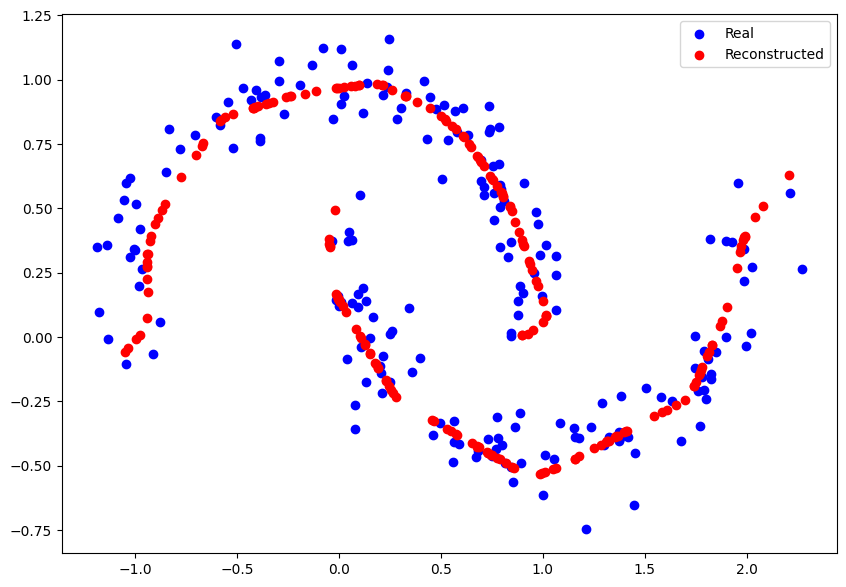

In [15]:
reconstruction_error_with_bottleneck, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,dev=DEVICE)

plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy())

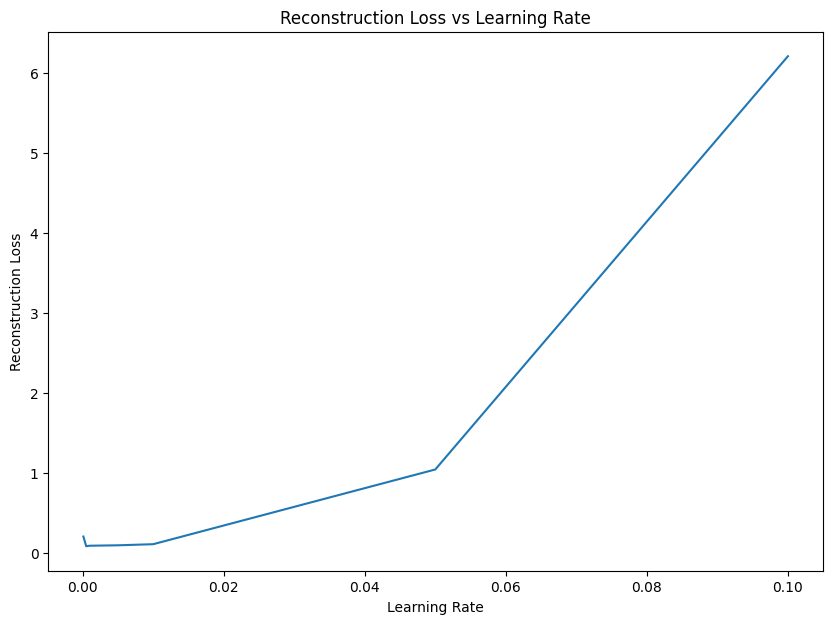

In [11]:
## Effect of learning rate on the reconstruction loss | should take around 4 mins

'''
Configuration: 

1000 samples of the dataset
*vary learning rate
keep autoencoder configuration constant
keep number of training and reconstruciton epochs constant
'''

lrs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]

reconstruction_losses_vs_lr = []

for lr in lrs:
    autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
    criterion     = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = lr)
    Losses = train_autoencoder(train_loader,autoenc,optimizer,criterion,N= 100,dev = DEVICE)
    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=100,dev=DEVICE)
    reconstruction_losses_vs_lr += [loss]

    ## create a plot for each one and save the image
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(),show_plot=False,save_path="autoenc_lrs/lrs_{}.png".format(lr))


## plot reconstruction loss vs learning rate
plt.figure(figsize=(10, 7))
plt.plot(lrs,reconstruction_losses_vs_lr)
plt.title("Reconstruction Loss vs Learning Rate")
plt.xlabel('Learning Rate')
plt.ylabel('Reconstruction Loss')
plt.show()

    



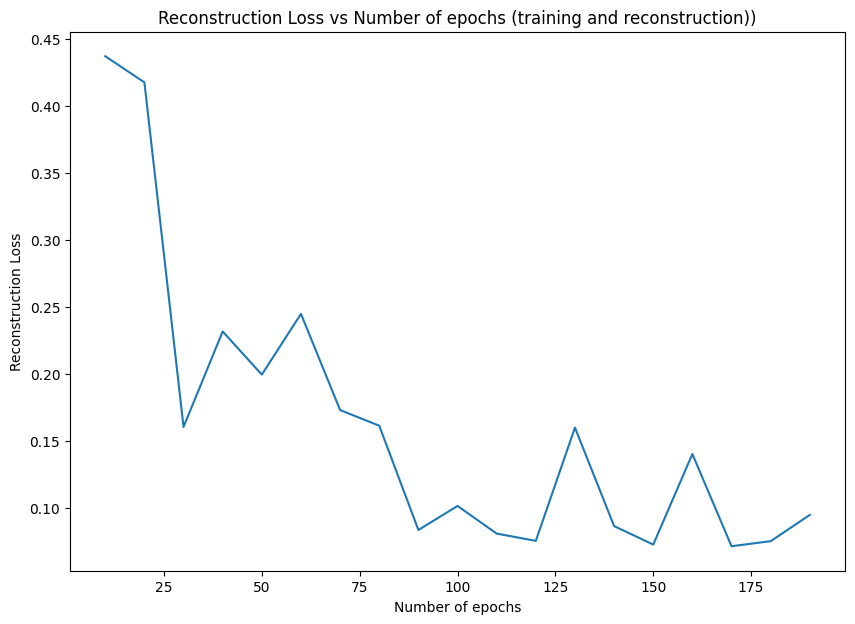

In [12]:
## Effect of number of epochs on the reconstruction loss

'''
Configuration: 

1000 samples of the dataset
lr: 0.001
keep autoencoder configuration constant
*vary number of training and reconstruction epochs
'''


epochs = np.arange(10,200,10)

reconstruction_losses_vs_epochs = []

for epoch in epochs:
    autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
    criterion     = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
    Losses = train_autoencoder(train_loader,autoenc,optimizer,criterion,N= epoch ,dev = DEVICE)
    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=epoch,dev=DEVICE)
    reconstruction_losses_vs_epochs += [loss]

    ## create a plot for each one and save the image
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(),show_plot=False,save_path="autoenc_epochs/epoch_{}.png".format(epoch))



## plot reconstruction loss vs learning rate
plt.figure(figsize=(10, 7))
plt.plot(epochs,reconstruction_losses_vs_epochs)
plt.title("Reconstruction Loss vs Number of epochs (training and reconstruction))")
plt.xlabel('Number of epochs')
plt.ylabel('Reconstruction Loss')
plt.show()

    



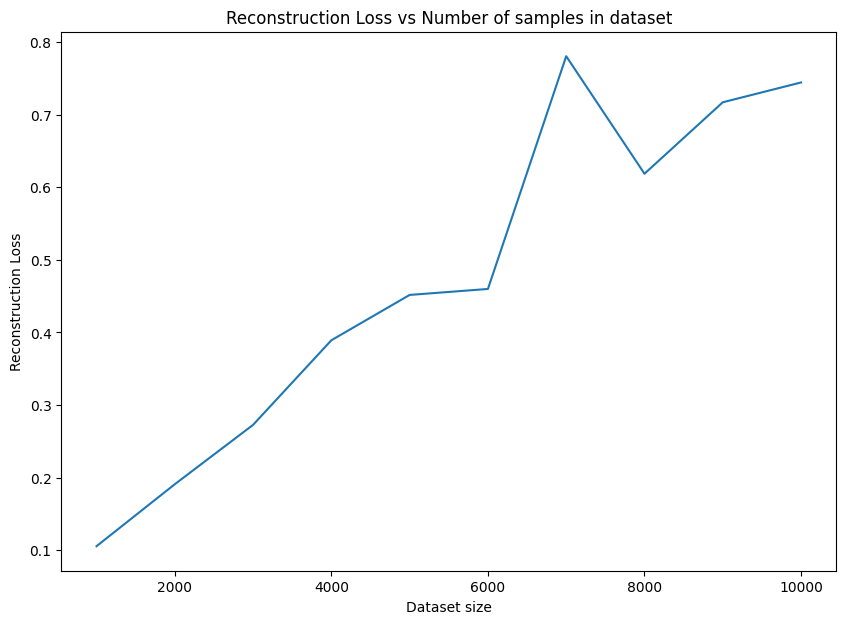

In [13]:
## Effect of size of the dataset on the reconstruction loss

'''
Configuration: 

*vary number of samples of the dataset
lr: 0.001
keep autoencoder configuration constant
100 epochs for training and reconstruction
'''

sample_sizes = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
train_loaders = []
test_loaders = []
X_test_splits = []

for sample_size in sample_sizes:
    # Step 1: Generate the two moons dataset
    X, y = make_moons(n_samples=sample_size, noise=0.1, random_state=SEED)

    # Step 2: Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Step 3: Convert the NumPy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    # Step 4: Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Step 5: Create DataLoader
    batch_size = 16
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    train_loaders.append(train_loader)
    test_loaders.append(test_loader)
    X_test_splits.append(X_test)


reconstruction_losses_vs_datasete_samples = []

for train_loader,test_loader,X_test in zip(train_loaders,test_loaders,X_test_splits):

    autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
    criterion     = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
    Losses = train_autoencoder(train_loader,autoenc,optimizer,criterion,N= epoch ,dev = DEVICE)
    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=epoch,dev=DEVICE)
    reconstruction_losses_vs_datasete_samples += [loss]

    ## create a plot for each one and save the image
    ## BUG: the name of the file is not correct, it has to be multiplied with batch size to be accurate
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(),show_plot=False,save_path="autoenc_dataset_size/size_{}.png".format(len(train_loader)))




## plot reconstruction loss vs learning rate
plt.figure(figsize=(10, 7))
plt.plot(sample_sizes,reconstruction_losses_vs_datasete_samples)
plt.title("Reconstruction Loss vs Number of samples in dataset")
plt.xlabel('Dataset size')
plt.ylabel('Reconstruction Loss')
plt.show()

    

In [11]:
train_loader_1,test_loader_1, X_train_1, X_test_1, y_train_1, y_test_1 = make_dataset(5000,0.1,SEED)
train_loader_2,test_loader_2, X_train_2, X_test_2, y_train_2, y_test_2 = make_dataset(5000,0.2,SEED)

Reconstruction loss on dataset 2: 0.1814454714767635


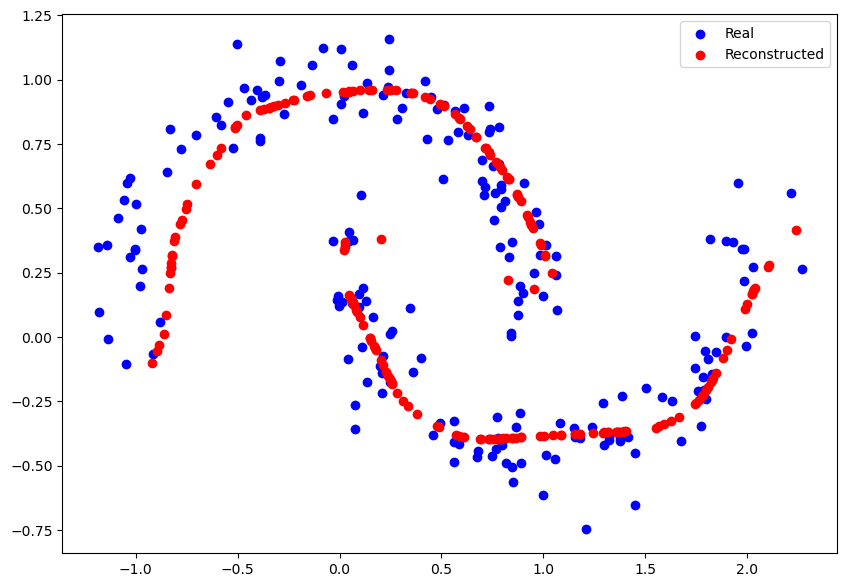

In [12]:
## Task 1.4

autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
criterion     = torch.nn.MSELoss()


## train on the first dataset
Losses_1 = train_autoencoder(train_loader_1,autoenc,optimizer,criterion,N= 100,dev = DEVICE)


## reconstruct on the second dataset
loss, reconstructed_outputs = reconstruct(test_loader_2,autoenc,criterion,N=100,dev=DEVICE)

print("Reconstruction loss on dataset 2: {}".format(loss))

plot_reconstructed_2d_data(X_test_2,reconstructed_outputs.cpu().numpy())

## seems to work pretty good

Reconstruction loss on dataset 2: 0.15813623508438468


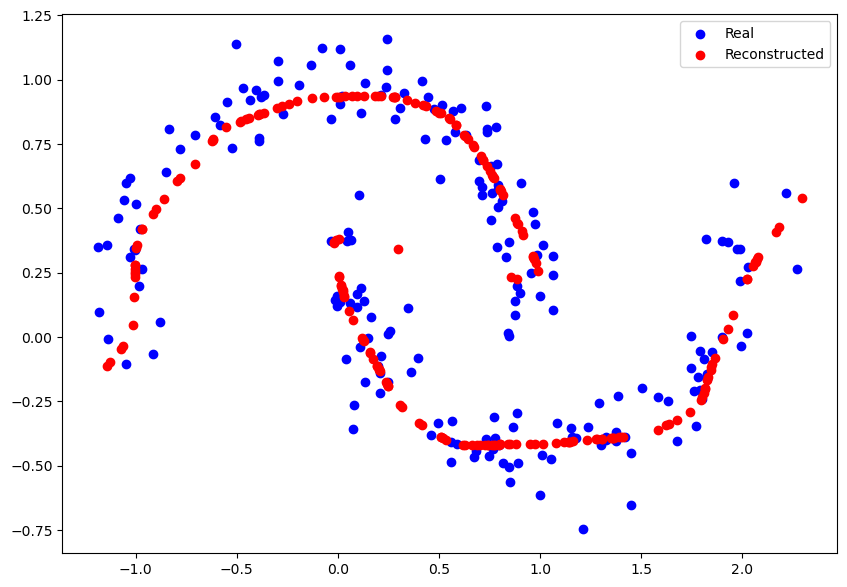

In [13]:
## Task 1.5

autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
criterion     = torch.nn.MSELoss()

## train on noise 0.2 dataset
Losses_2 = train_autoencoder(train_loader_2,autoenc,optimizer,criterion,N= 100,dev = DEVICE)


## reconstruct on the 0.2 noise dataset
loss, reconstructed_outputs = reconstruct(test_loader_2,autoenc,criterion,N=100,dev=DEVICE)


print("Reconstruction loss on dataset 2: {}".format(loss))


plot_reconstructed_2d_data(X_test_2,reconstructed_outputs.cpu().numpy())

## to me it looks a bit like overfitting every cloud of points

## 2. Two-dimensional data without bottleneck

MMD implementation is based on the sample solution from Exercise 1. We have modified it so that it matches the definition from the lecture.

In [10]:
def squared_exponential_kernel(x1, x2, h = 1):
    return np.exp(-(np.linalg.norm(x1 - x2) ** 2) / (2 * h))

def inverse_multi_quadratic_kernel(x1, x2, h):
    return 1 / ((np.linalg.norm(x1 - x2) ** 2) / h + 1)

In [41]:
def mmd2(X_true, X_pred, kernel, bandwidth, independent):
    M, N = X_pred.shape[0], X_true.shape[0]

    repulsive = 1 / (M * (M - 1)) * np.sum(
        np.fromiter((kernel(X_pred[i], X_pred[j], bandwidth) for i in range(M) for j in range(M) if i != j), float)
    )

    attractive = 2 / (M * N) * np.sum(
        np.fromiter((kernel(X_pred[i], X_true[j], bandwidth) for i in range(M) for j in range(N)), float)
    )

    return repulsive + independent - attractive


In [42]:
def compute_independent(X_true, kernel, bandwidth):
    N = X_true.shape[0]
    independent = 1 / (N * (N-1)) * np.sum([kernel(X_true[i], X_true[j], bandwidth) \
                                            for i in range(N) \
                                                for  j in [k for k in range(N) if k != i]])
    return independent

### Train autoencoder without bottleneck

In [43]:
def train_mmd_autoencoder(loader, standard_normal_samples, model, optimizer, kernel, bandwidth, weighting_factor,
          N   = 25,
          dev = 'cuda',
          vectorized_data_dimension=2,
          verbose=False):
    '''Train network

       Parameters:
           loader       Used to get data
           model        Model to be trained
           optimizer    Used to minimze errors
      Keyword parameters:
          N             Number of epochs
          dev           Device - cpu or cuda
    '''
    Losses = []
    independent = compute_independent(standard_normal_samples, kernel, bandwidth)

    for epoch in tqdm(range(N)):
        loss = 0
        for batch_features, _ in loader:
            batch_features = batch_features.view(-1, vectorized_data_dimension).to(dev) 
            optimizer.zero_grad()
            outputs = model(batch_features)
            codes = model.encoder(batch_features)
            criterion = torch.nn.MSELoss()
            rec_loss = criterion(outputs, batch_features)
            mmd2_loss = mmd2(standard_normal_samples, codes.detach().numpy(), kernel, bandwidth, independent)
            train_loss = rec_loss + weighting_factor * mmd2_loss
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        print(f"Rec_loss: {rec_loss:.2f}, MMD_loss: {mmd2_loss:.2f}")
        Losses.append(loss / len(loader))
        
        if verbose:
            print(f'epoch : {epoch+1}/{N}, loss = {Losses[-1]:.6f}')

    return Losses

In [44]:
def reconstruct_without_bottleneck(loader,model,
                vectorized_data_dimension=2,
                dev = None,):
    
    loss = 0.0
    reconstructed_outputs = []
    all_codes = []
    with torch.no_grad():
        for i,(batch_features, _) in enumerate(loader):
            batch_features = batch_features.view(-1, vectorized_data_dimension).to(dev)
            outputs        = model(batch_features)
            codes          = model.encoder(batch_features)
            all_codes.append(codes)
            reconstructed_outputs.append(outputs)
            criterion      = torch.nn.MSELoss()
            test_loss      = criterion(outputs, batch_features)
            loss          += test_loss.item()
            

    return loss, torch.cat(reconstructed_outputs,dim=0), all_codes

In [45]:
batch_size = 64
weighting_factor = 2
mean = [0, 0]
cov = [[1, 0], [0, 1]]
bandwidths = [0.25, 0.5, 1., 2., 4., 8.]
nr_samples = batch_size
standard_normal_samples = np.random.multivariate_normal(mean, cov, nr_samples)
train_loader, test_loader, X_train, X_test, y_train, y_test = make_dataset(no_samples = DATASET_SAMPLES, 
                                                                           noise = 0.1, 
                                                                           random_state = SEED,
                                                                           batch_size = batch_size)
kernel = squared_exponential_kernel

In [46]:
reconstruction_errors = []
all_codes = []
for bandwidth in bandwidths:
    autoenc_without_bottleneck = Autoencoder(input_dim=2,h_dim=100,latent_dim=2,layers=3)
    optimizer = torch.optim.Adam(autoenc_without_bottleneck.parameters(),lr = LR)

    # train autoencoder without bottleneck
    Losses = train_mmd_autoencoder(train_loader, standard_normal_samples, autoenc_without_bottleneck,optimizer,kernel,bandwidth, weighting_factor, N = 25,dev = DEVICE)

    # reconstruct test data and plot initial test data + reconstructed data
    loss, reconstructed_outputs, codes = reconstruct_without_bottleneck(test_loader,autoenc_without_bottleneck, dev=DEVICE)
    reconstruction_errors.append(loss)
    all_codes.append(codes)
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(), show_plot=False, save_path="autoenc_without_bottleneck/bandwidth_{}.png".format(bandwidth))  

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:14,  1.71it/s]

Rec_loss: 0.40, MMD_loss: 0.37


  8%|▊         | 2/25 [00:01<00:13,  1.70it/s]

Rec_loss: 0.08, MMD_loss: 0.13


 12%|█▏        | 3/25 [00:01<00:13,  1.58it/s]

Rec_loss: 0.04, MMD_loss: 0.09


 16%|█▌        | 4/25 [00:02<00:12,  1.63it/s]

Rec_loss: 0.01, MMD_loss: 0.04


 20%|██        | 5/25 [00:03<00:12,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 24%|██▍       | 6/25 [00:03<00:11,  1.68it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 28%|██▊       | 7/25 [00:04<00:10,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.10


 32%|███▏      | 8/25 [00:04<00:10,  1.58it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 36%|███▌      | 9/25 [00:05<00:10,  1.59it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 40%|████      | 10/25 [00:06<00:09,  1.63it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 44%|████▍     | 11/25 [00:06<00:08,  1.60it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 48%|████▊     | 12/25 [00:07<00:09,  1.39it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 52%|█████▏    | 13/25 [00:08<00:09,  1.25it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 56%|█████▌    | 14/25 [00:09<00:08,  1.29it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 60%|██████    | 15/25 [00:10<00:07,  1.39it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 64%|██████▍   | 16/25 [00:10<00:06,  1.47it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 68%|██████▊   | 17/25 [00:11<00:05,  1.54it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 72%|███████▏  | 18/25 [00:11<00:04,  1.58it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 76%|███████▌  | 19/25 [00:12<00:03,  1.61it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 80%|████████  | 20/25 [00:12<00:03,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 84%|████████▍ | 21/25 [00:13<00:02,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.10


 88%|████████▊ | 22/25 [00:14<00:01,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 92%|█████████▏| 23/25 [00:14<00:01,  1.61it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 96%|█████████▌| 24/25 [00:15<00:00,  1.63it/s]

Rec_loss: 0.00, MMD_loss: 0.06


100%|██████████| 25/25 [00:16<00:00,  1.56it/s]


Rec_loss: 0.00, MMD_loss: 0.09


  4%|▍         | 1/25 [00:00<00:13,  1.74it/s]

Rec_loss: 0.35, MMD_loss: 0.33


  8%|▊         | 2/25 [00:01<00:13,  1.72it/s]

Rec_loss: 0.12, MMD_loss: 0.13


 12%|█▏        | 3/25 [00:01<00:12,  1.72it/s]

Rec_loss: 0.06, MMD_loss: 0.13


 16%|█▌        | 4/25 [00:02<00:12,  1.73it/s]

Rec_loss: 0.01, MMD_loss: 0.06


 20%|██        | 5/25 [00:03<00:13,  1.46it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 24%|██▍       | 6/25 [00:04<00:14,  1.28it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 28%|██▊       | 7/25 [00:04<00:14,  1.28it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 32%|███▏      | 8/25 [00:05<00:12,  1.34it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 36%|███▌      | 9/25 [00:06<00:11,  1.39it/s]

Rec_loss: 0.00, MMD_loss: 0.11


 40%|████      | 10/25 [00:07<00:10,  1.37it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 44%|████▍     | 11/25 [00:07<00:10,  1.35it/s]

Rec_loss: 0.00, MMD_loss: 0.11


 48%|████▊     | 12/25 [00:08<00:09,  1.40it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 52%|█████▏    | 13/25 [00:09<00:08,  1.47it/s]

Rec_loss: 0.00, MMD_loss: 0.11


 56%|█████▌    | 14/25 [00:09<00:07,  1.53it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 60%|██████    | 15/25 [00:10<00:06,  1.56it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 64%|██████▍   | 16/25 [00:10<00:05,  1.59it/s]

Rec_loss: 0.00, MMD_loss: 0.10


 68%|██████▊   | 17/25 [00:11<00:04,  1.62it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 72%|███████▏  | 18/25 [00:12<00:04,  1.63it/s]

Rec_loss: 0.00, MMD_loss: 0.12


 76%|███████▌  | 19/25 [00:12<00:03,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 80%|████████  | 20/25 [00:13<00:03,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 84%|████████▍ | 21/25 [00:13<00:02,  1.63it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 88%|████████▊ | 22/25 [00:14<00:01,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.10


 92%|█████████▏| 23/25 [00:15<00:01,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.13


 96%|█████████▌| 24/25 [00:15<00:00,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.11


100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Rec_loss: 0.00, MMD_loss: 0.07


  4%|▍         | 1/25 [00:00<00:14,  1.70it/s]

Rec_loss: 0.41, MMD_loss: 0.24


  8%|▊         | 2/25 [00:01<00:13,  1.69it/s]

Rec_loss: 0.06, MMD_loss: 0.09


 12%|█▏        | 3/25 [00:01<00:13,  1.67it/s]

Rec_loss: 0.01, MMD_loss: 0.03


 16%|█▌        | 4/25 [00:02<00:12,  1.66it/s]

Rec_loss: 0.01, MMD_loss: 0.05


 20%|██        | 5/25 [00:03<00:12,  1.63it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 24%|██▍       | 6/25 [00:03<00:11,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 28%|██▊       | 7/25 [00:04<00:10,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.02


 32%|███▏      | 8/25 [00:04<00:10,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.02


 36%|███▌      | 9/25 [00:05<00:09,  1.67it/s]

Rec_loss: 0.00, MMD_loss: 0.02


 40%|████      | 10/25 [00:06<00:09,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 44%|████▍     | 11/25 [00:06<00:08,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 48%|████▊     | 12/25 [00:07<00:07,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 52%|█████▏    | 13/25 [00:07<00:07,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 56%|█████▌    | 14/25 [00:08<00:06,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 60%|██████    | 15/25 [00:09<00:06,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 64%|██████▍   | 16/25 [00:09<00:05,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 68%|██████▊   | 17/25 [00:10<00:04,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.02


 72%|███████▏  | 18/25 [00:10<00:04,  1.67it/s]

Rec_loss: 0.00, MMD_loss: 0.02


 76%|███████▌  | 19/25 [00:11<00:03,  1.68it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 80%|████████  | 20/25 [00:12<00:02,  1.67it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 84%|████████▍ | 21/25 [00:12<00:02,  1.67it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 88%|████████▊ | 22/25 [00:13<00:01,  1.67it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 92%|█████████▏| 23/25 [00:13<00:01,  1.67it/s]

Rec_loss: 0.00, MMD_loss: 0.02


 96%|█████████▌| 24/25 [00:14<00:00,  1.67it/s]

Rec_loss: 0.00, MMD_loss: 0.09


100%|██████████| 25/25 [00:15<00:00,  1.66it/s]


Rec_loss: 0.00, MMD_loss: 0.04


  4%|▍         | 1/25 [00:00<00:13,  1.73it/s]

Rec_loss: 0.26, MMD_loss: 0.17


  8%|▊         | 2/25 [00:01<00:13,  1.69it/s]

Rec_loss: 0.08, MMD_loss: 0.06


 12%|█▏        | 3/25 [00:01<00:13,  1.67it/s]

Rec_loss: 0.02, MMD_loss: 0.04


 16%|█▌        | 4/25 [00:02<00:12,  1.67it/s]

Rec_loss: 0.01, MMD_loss: 0.07


 20%|██        | 5/25 [00:02<00:12,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 24%|██▍       | 6/25 [00:03<00:11,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 28%|██▊       | 7/25 [00:04<00:10,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 32%|███▏      | 8/25 [00:04<00:10,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 36%|███▌      | 9/25 [00:05<00:09,  1.67it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 40%|████      | 10/25 [00:05<00:09,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 44%|████▍     | 11/25 [00:06<00:08,  1.68it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 48%|████▊     | 12/25 [00:07<00:07,  1.68it/s]

Rec_loss: 0.00, MMD_loss: 0.13


 52%|█████▏    | 13/25 [00:07<00:07,  1.69it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 56%|█████▌    | 14/25 [00:08<00:06,  1.70it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 60%|██████    | 15/25 [00:08<00:05,  1.70it/s]

Rec_loss: 0.00, MMD_loss: 0.20


 64%|██████▍   | 16/25 [00:09<00:05,  1.70it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 68%|██████▊   | 17/25 [00:10<00:04,  1.70it/s]

Rec_loss: 0.00, MMD_loss: 0.12


 72%|███████▏  | 18/25 [00:10<00:04,  1.70it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 76%|███████▌  | 19/25 [00:11<00:03,  1.67it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 80%|████████  | 20/25 [00:11<00:02,  1.68it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 84%|████████▍ | 21/25 [00:12<00:02,  1.69it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 88%|████████▊ | 22/25 [00:13<00:01,  1.69it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 92%|█████████▏| 23/25 [00:13<00:01,  1.70it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 96%|█████████▌| 24/25 [00:14<00:00,  1.69it/s]

Rec_loss: 0.00, MMD_loss: 0.08


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Rec_loss: 0.00, MMD_loss: 0.04


  4%|▍         | 1/25 [00:00<00:15,  1.53it/s]

Rec_loss: 0.41, MMD_loss: 0.07


  8%|▊         | 2/25 [00:01<00:14,  1.56it/s]

Rec_loss: 0.09, MMD_loss: 0.04


 12%|█▏        | 3/25 [00:01<00:14,  1.52it/s]

Rec_loss: 0.07, MMD_loss: 0.04


 16%|█▌        | 4/25 [00:02<00:14,  1.47it/s]

Rec_loss: 0.05, MMD_loss: 0.03


 20%|██        | 5/25 [00:03<00:13,  1.45it/s]

Rec_loss: 0.01, MMD_loss: 0.07


 24%|██▍       | 6/25 [00:04<00:13,  1.45it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 28%|██▊       | 7/25 [00:04<00:12,  1.50it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 32%|███▏      | 8/25 [00:05<00:11,  1.54it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 36%|███▌      | 9/25 [00:05<00:10,  1.58it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 40%|████      | 10/25 [00:06<00:09,  1.60it/s]

Rec_loss: 0.00, MMD_loss: 0.10


 44%|████▍     | 11/25 [00:07<00:08,  1.62it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 48%|████▊     | 12/25 [00:07<00:08,  1.60it/s]

Rec_loss: 0.00, MMD_loss: 0.11


 52%|█████▏    | 13/25 [00:08<00:07,  1.61it/s]

Rec_loss: 0.00, MMD_loss: 0.11


 56%|█████▌    | 14/25 [00:08<00:06,  1.61it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 60%|██████    | 15/25 [00:09<00:06,  1.54it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 64%|██████▍   | 16/25 [00:10<00:05,  1.57it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 68%|██████▊   | 17/25 [00:10<00:05,  1.59it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 72%|███████▏  | 18/25 [00:11<00:04,  1.61it/s]

Rec_loss: 0.00, MMD_loss: 0.12


 76%|███████▌  | 19/25 [00:12<00:03,  1.62it/s]

Rec_loss: 0.00, MMD_loss: 0.13


 80%|████████  | 20/25 [00:12<00:03,  1.63it/s]

Rec_loss: 0.00, MMD_loss: 0.11


 84%|████████▍ | 21/25 [00:13<00:02,  1.63it/s]

Rec_loss: 0.00, MMD_loss: 0.10


 88%|████████▊ | 22/25 [00:13<00:01,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.12


 92%|█████████▏| 23/25 [00:14<00:01,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.13


 96%|█████████▌| 24/25 [00:15<00:00,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.08


100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


Rec_loss: 0.00, MMD_loss: 0.10


  4%|▍         | 1/25 [00:00<00:14,  1.70it/s]

Rec_loss: 0.33, MMD_loss: 0.04


  8%|▊         | 2/25 [00:01<00:13,  1.67it/s]

Rec_loss: 0.08, MMD_loss: 0.02


 12%|█▏        | 3/25 [00:01<00:13,  1.65it/s]

Rec_loss: 0.04, MMD_loss: 0.06


 16%|█▌        | 4/25 [00:02<00:12,  1.62it/s]

Rec_loss: 0.02, MMD_loss: 0.03


 20%|██        | 5/25 [00:03<00:12,  1.63it/s]

Rec_loss: 0.00, MMD_loss: 0.13


 24%|██▍       | 6/25 [00:03<00:11,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 28%|██▊       | 7/25 [00:04<00:10,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 32%|███▏      | 8/25 [00:04<00:10,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 36%|███▌      | 9/25 [00:05<00:09,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 40%|████      | 10/25 [00:06<00:09,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 44%|████▍     | 11/25 [00:06<00:08,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 48%|████▊     | 12/25 [00:07<00:07,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.02


 52%|█████▏    | 13/25 [00:08<00:07,  1.54it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 56%|█████▌    | 14/25 [00:08<00:07,  1.54it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 60%|██████    | 15/25 [00:09<00:06,  1.57it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 64%|██████▍   | 16/25 [00:09<00:05,  1.59it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 68%|██████▊   | 17/25 [00:10<00:04,  1.60it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 72%|███████▏  | 18/25 [00:11<00:04,  1.61it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 76%|███████▌  | 19/25 [00:11<00:03,  1.59it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 80%|████████  | 20/25 [00:12<00:03,  1.54it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 84%|████████▍ | 21/25 [00:13<00:02,  1.54it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 88%|████████▊ | 22/25 [00:13<00:01,  1.57it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 92%|█████████▏| 23/25 [00:14<00:01,  1.56it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 96%|█████████▌| 24/25 [00:15<00:00,  1.57it/s]

Rec_loss: 0.00, MMD_loss: 0.07


100%|██████████| 25/25 [00:15<00:00,  1.60it/s]

Rec_loss: 0.00, MMD_loss: -0.00


### Reconstruction errors for kernel with different bandwidths

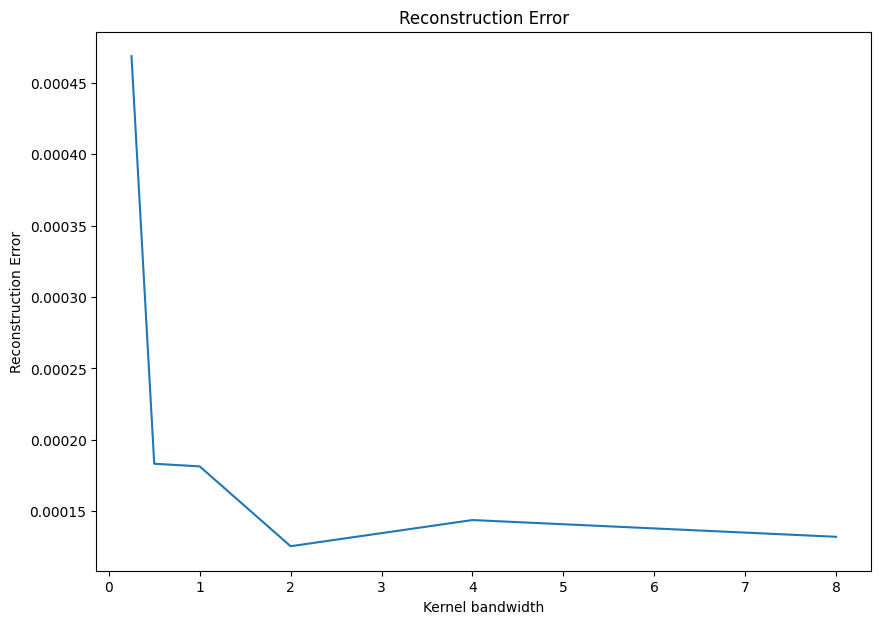

In [47]:
plt.figure(figsize=(10, 7))
plt.plot(bandwidths, reconstruction_errors)
plt.title("Reconstruction Error")
plt.xlabel('Kernel bandwidth')
plt.ylabel('Reconstruction Error')
plt.show()

### Code distribution for kernel with different bandwidths

In [48]:
def plot_code_distribution(codes, bandwidth, show_plot=True,save_path=None):
    codes_list = element_list = [item for tensor in codes for item in tensor.tolist()]
    x = [code[0] for code in codes_list]
    y = [code[1] for code in codes_list]
    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, c='b', label='Codes')
    plt.legend()
    plt.title(f"Code distribution for bandwidth {bandwidth}")

    if save_path is not None:
        plt.savefig(save_path)

    if show_plot:
        plt.show()
    else:
        plt.close()

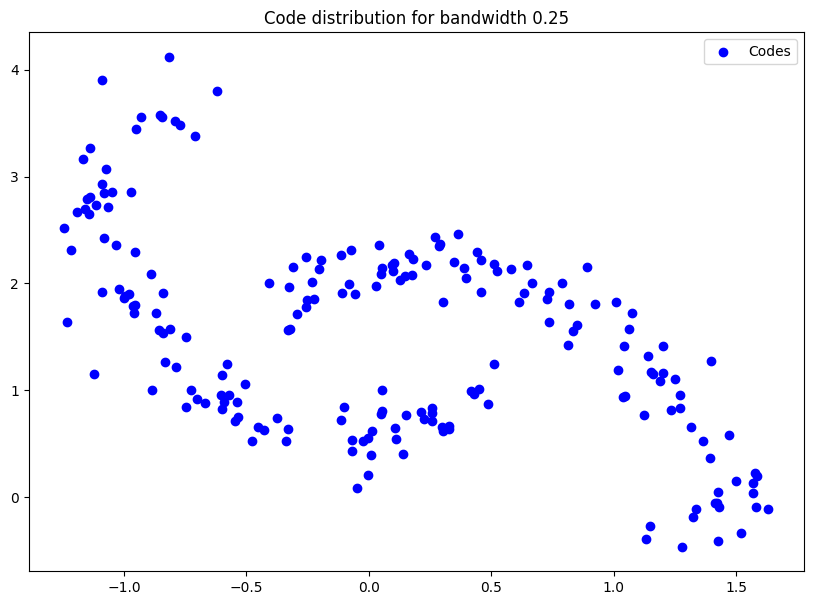

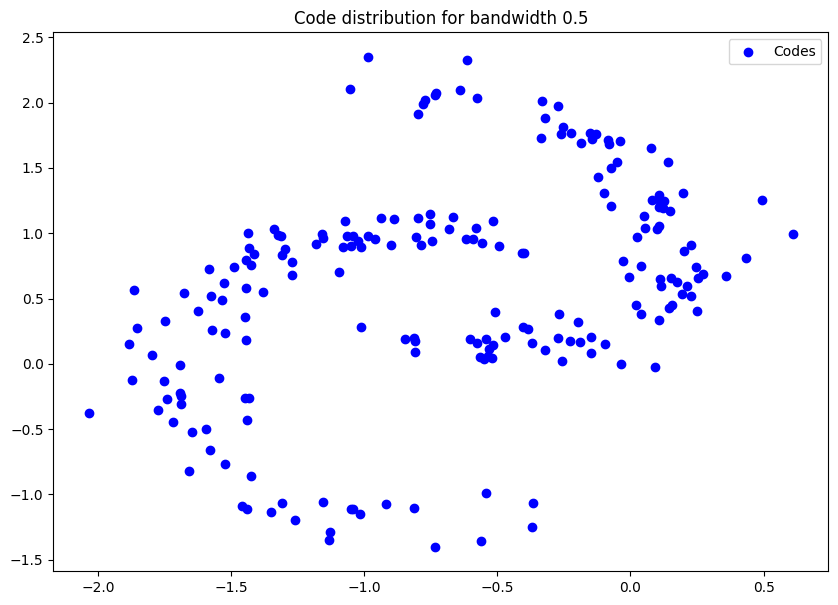

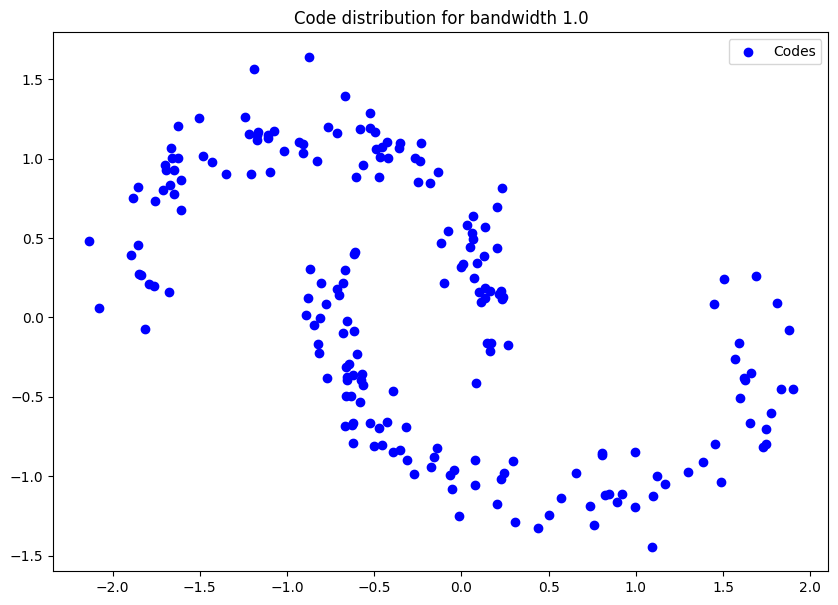

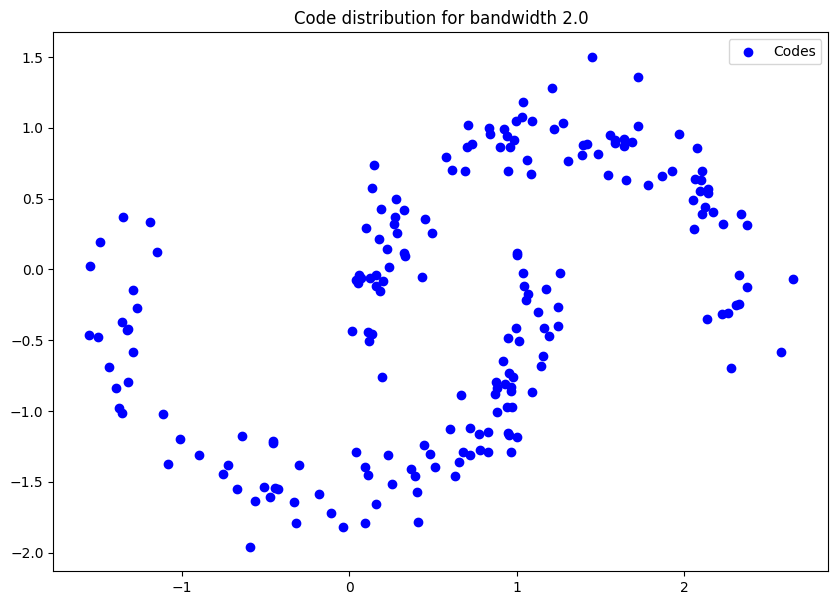

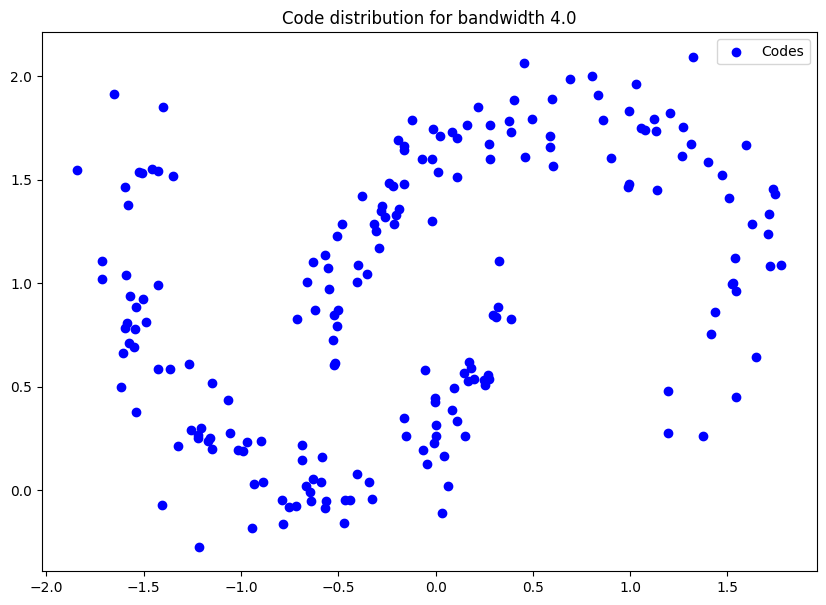

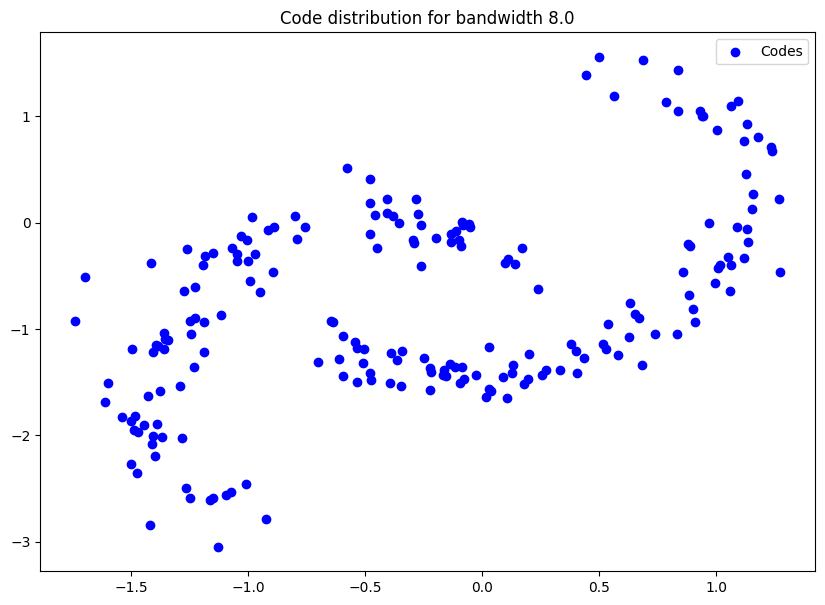

In [54]:
for codes, bandwidth in zip(all_codes, bandwidths):
    plot_code_distribution(codes, bandwidth)

### Generation of new data

In [50]:
def generate_data(nr_samples, autoenc_without_bottleneck):
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    code_samples = torch.FloatTensor(np.random.multivariate_normal(mean, cov, nr_samples))
    with torch.no_grad():
        new_data = autoenc_without_bottleneck.decoder(code_samples)
    return new_data

In [51]:
nr_samples = 1000
nr_training_samples = 1000
bwidth = 1
batch_size = 64
weighting_factor = 2
autoenc_without_bottleneck = Autoencoder(input_dim=2,h_dim=100,latent_dim=2,layers=3)
optimizer = torch.optim.Adam(autoenc_without_bottleneck.parameters(),lr = LR)
train_loader, test_loader, X_train, X_test, y_train, y_test = make_dataset(no_samples = nr_training_samples, 
                                                                           noise = 0.1, 
                                                                           random_state = SEED,
                                                                           batch_size = batch_size)
Losses = train_mmd_autoencoder(train_loader, standard_normal_samples, autoenc_without_bottleneck,optimizer,kernel,bwidth, weighting_factor, N = 25,dev = DEVICE)

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:14,  1.67it/s]

Rec_loss: 0.41, MMD_loss: 0.28


  8%|▊         | 2/25 [00:01<00:13,  1.69it/s]

Rec_loss: 0.15, MMD_loss: 0.08


 12%|█▏        | 3/25 [00:01<00:12,  1.71it/s]

Rec_loss: 0.05, MMD_loss: 0.08


 16%|█▌        | 4/25 [00:02<00:12,  1.72it/s]

Rec_loss: 0.02, MMD_loss: 0.04


 20%|██        | 5/25 [00:02<00:12,  1.65it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 24%|██▍       | 6/25 [00:03<00:11,  1.64it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 28%|██▊       | 7/25 [00:04<00:10,  1.66it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 32%|███▏      | 8/25 [00:04<00:10,  1.68it/s]

Rec_loss: 0.00, MMD_loss: 0.11


 36%|███▌      | 9/25 [00:05<00:09,  1.70it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 40%|████      | 10/25 [00:05<00:08,  1.71it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 44%|████▍     | 11/25 [00:06<00:08,  1.72it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 48%|████▊     | 12/25 [00:07<00:07,  1.73it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 52%|█████▏    | 13/25 [00:07<00:06,  1.74it/s]

Rec_loss: 0.00, MMD_loss: 0.09


 56%|█████▌    | 14/25 [00:08<00:06,  1.72it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 60%|██████    | 15/25 [00:08<00:05,  1.73it/s]

Rec_loss: 0.00, MMD_loss: 0.04


 64%|██████▍   | 16/25 [00:09<00:05,  1.73it/s]

Rec_loss: 0.00, MMD_loss: 0.08


 68%|██████▊   | 17/25 [00:09<00:04,  1.73it/s]

Rec_loss: 0.00, MMD_loss: 0.03


 72%|███████▏  | 18/25 [00:10<00:04,  1.74it/s]

Rec_loss: 0.00, MMD_loss: 0.12


 76%|███████▌  | 19/25 [00:11<00:03,  1.74it/s]

Rec_loss: 0.00, MMD_loss: 0.07


 80%|████████  | 20/25 [00:11<00:02,  1.75it/s]

Rec_loss: 0.00, MMD_loss: 0.06


 84%|████████▍ | 21/25 [00:12<00:02,  1.74it/s]

Rec_loss: 0.00, MMD_loss: 0.10


 88%|████████▊ | 22/25 [00:12<00:01,  1.75it/s]

Rec_loss: 0.00, MMD_loss: 0.05


 92%|█████████▏| 23/25 [00:13<00:01,  1.72it/s]

Rec_loss: 0.00, MMD_loss: 0.12


 96%|█████████▌| 24/25 [00:13<00:00,  1.73it/s]

Rec_loss: 0.00, MMD_loss: 0.08


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]

Rec_loss: 0.00, MMD_loss: 0.07


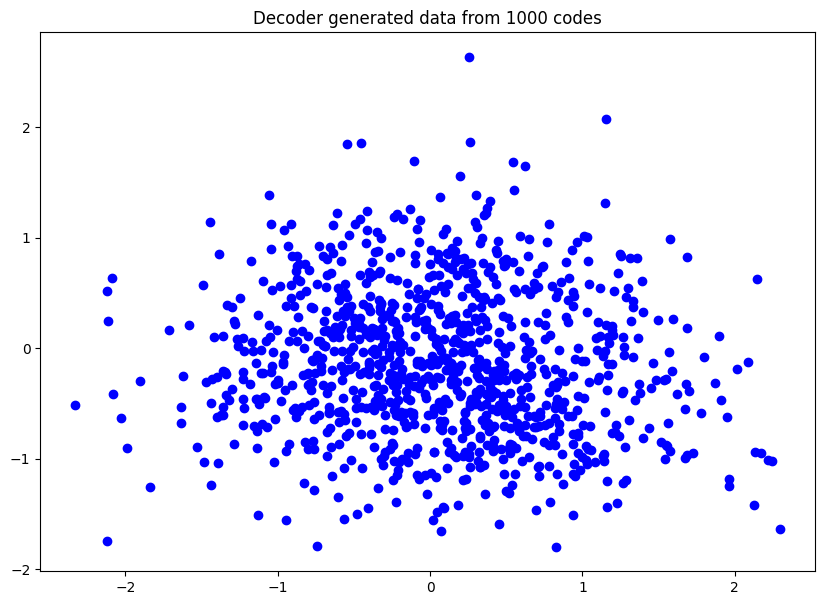

In [52]:
new_data = generate_data(nr_samples, autoenc_without_bottleneck)
data_list = [item for item in new_data.tolist()]
x = [data[0] for data in data_list]
y = [data[1] for data in data_list]
plt.figure(figsize=(10, 7))
plt.title(f"Decoder generated data from {nr_samples} codes")
plt.scatter(x, y, c='b')
plt.show()